In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import h5py
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [8]:
class Config:
    SIGNALS_PATH = '/home/hbakhshi/Desktop/Projects/Computational/Data/'
    BKG_PATH = '/home/hbakhshi/Desktop/Projects/Computational/Data'
    SIGNALS = ['WZ_jjnunu_pT_450_1200_test.h5']
    BKGS = ['QCDjj_pT_450_1200_test.h5']
    IMAGE_SIZE = 32
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-3
    NUM_CLASSES = 2        
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def AllFiles():
    ret = []
    for signal in Config.SIGNALS:
        ret.append(Path(Config.SIGNALS_PATH) / signal)
    for bkg in Config.BKGS:
        ret.append(Path(Config.BKG_PATH) / bkg)
    return ret
def GetLabels():
    labels = []
    for signal in Config.SIGNALS:
        labels.append(1)  # Signal class
    for bkg in Config.BKGS:
        labels.append(0)  # Background class
    return labels






In [22]:
def create_image(pt, mass , charge , eta, phi, size):
    image = np.zeros((size, size , 3), dtype=np.float32)

    min_eta = np.min(eta)
    max_eta = np.max(eta)
    phi = np.mod(phi + np.pi, 2 * np.pi) - np.pi

    eta_idx = (((eta - min_eta) / (max_eta - min_eta)) * (size - 1)).astype(int)
    phi_idx = (((phi + np.pi) / (2 * np.pi)) * (size - 1)).astype(int)

    for i in range(len(pt)):
        if pt[i] > 0:
            x, y = eta_idx[i], phi_idx[i]
            image[y, x , 0] += pt[i]
            image[y, x , 1] += mass[i]
            image[y, x , 2] += charge[i]
    
    image[:,:,0] /= np.max(image[:,:,0]) if np.max(image[:,:,0]) > 0 else 1
    image[:,:,1] /= np.max(image[:,:,1]) if np.max(image[:,:,1]) > 0 else 1
    image[:,:,2] /= np.max(image[:,:,2]) if np.max(image[:,:,2]) > 0 else 1

    return image


In [23]:
class JetImageDataset(Dataset):
    def __init__(self, h5_paths, labels , image_size  , n_jets = -1):
        super(JetImageDataset, self).__init__()

        self.pt = None
        self.eta = None
        self.phi = None
        self.mass = None
        self.charge = None
        self.labels = np.array([])
        for h5_path , lbl in zip(h5_paths, labels):
            if not Path(h5_path).exists():
                raise FileNotFoundError(f"File {h5_path} does not exist.")
            with h5py.File(h5_path, 'r') as f:
                cnsts = f["objects/jets/jet1_cnsts"][:n_jets]
                #jets = f["objects/jets/jet1_obs"][:n_jets]
                if self.pt is None:
                    self.pt = cnsts[:,:,0]
                    self.eta = cnsts[:,:,1]
                    self.phi = cnsts[:,:,2]
                    self.mass = cnsts[:,:,3]
                    self.charge = cnsts[:,:,4]
                else:
                    self.pt = np.concatenate( [self.pt ,  cnsts[:,:,0]] )
                    self.eta = np.concatenate( [self.eta ,  cnsts[:,:,1]] )
                    self.phi = np.concatenate( [self.phi ,  cnsts[:,:,2]] )
                    self.mass = np.concatenate( [self.mass ,  cnsts[:,:,3]] )
                    self.charge = np.concatenate( [self.charge ,  cnsts[:,:,4]] )

                njets = cnsts.shape[0]
                self.labels = np.concatenate( [self.labels , np.full(njets, lbl)] )
        
        self.image_size = image_size

    def __len__(self):
        return len(self.pt)

    def __getitem__(self, idx):
        image = create_image(self.pt[idx] , self.mass[idx], self.charge[idx] ,  self.eta[idx], self.phi[idx], self.image_size)
        image = torch.tensor(image).unsqueeze(0)  # اضافه کردن کانال
        label = torch.tensor(self.labels[idx]).long()
        return image, label


In [24]:
j = JetImageDataset( AllFiles(), GetLabels(), Config.IMAGE_SIZE, n_jets=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


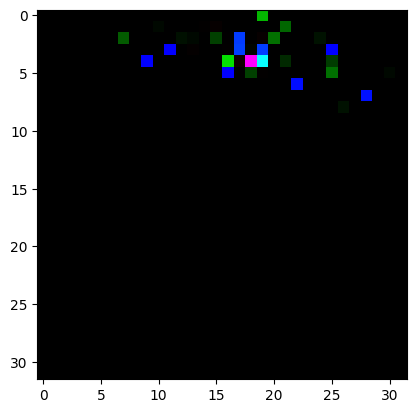

In [28]:
from matplotlib import pyplot as plt
plt.imshow( j[120][0][0,:,:,:] )

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * (Config.IMAGE_SIZE // 4) ** 2, 64), nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
def train(model, loader, criterion, optimizer, epochs, device):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"[Epoch {epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    return loss_history


In [ ]:
def plot_losses(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


In [ ]:
dataset = JetImageDataset(Config.FILE_PATH, Config.IMAGE_SIZE)
dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True)

model = CNNClassifier(Config.NUM_CLASSES).to(Config.DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LR)

losses = train(model, dataloader, criterion, optimizer, Config.EPOCHS, Config.DEVICE)

plot_losses(losses)
